In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install wordcloud matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 19.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 12.2 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 12.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 12.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 25.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------------------------------- ---- 2.4/2.7 MB 19.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input, Dense, Embedding, Dot, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,TensorBoard

from wordcloud import WordCloud
%matplotlib inline

#### Reading data

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [5]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv") , low_memory=True,usecols=["user_id","anime_id","rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
rating_df.describe()

,user_id,anime_id,rating
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.339305e+03,1.657369e+04,4.306854e+00
std,4.742759e+03,1.379504e+04,3.906990e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.291000e+03,3.297000e+03,0.000000e+00
50%,8.378000e+03,1.254900e+04,6.000000e+00
75%,1.242100e+04,3.091100e+04,8.000000e+00
max,1.650800e+04,4.849100e+04,1.000000e+01


#### Data Processing

In [ ]:
n_user = rating_df['user_id'].value_counts()

In [9]:
n_user

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [10]:
rating_df = rating_df[rating_df["user_id"].isin(n_user[n_user>=400].index)].copy()

In [11]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [12]:
len(rating_df)

3246641

In [13]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [14]:
avg_rating

np.float64(4.122732695114736)

In [15]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating))

In [16]:
np.mean(rating_df['rating'])

np.float64(0.4122732695114729)

In [17]:
rating_df.duplicated().sum()

np.int64(0)

In [18]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
user_ids = rating_df['user_id'].unique().tolist()

In [20]:
user2user_encoding = {x : i for i,x in enumerate(user_ids)}
user2user_decoding = {i : x for i,x in enumerate(user_ids)}

rating_df["user"] = rating_df['user_id'].map(user2user_encoding)

In [21]:
n_user = len(user_ids)

In [22]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [23]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoding = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoding = {i : x for i,x in enumerate(anime_ids)}

rating_df["anime"] = rating_df['anime_id'].map(anime2anime_encoding)

In [24]:
n_anime = len(anime2anime_encoding)

In [25]:
n_anime

17149

In [26]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [27]:
X = rating_df[['user','anime']]
y = rating_df["rating"]

In [28]:
test_size = 1000

In [29]:
train_indices = rating_df.shape[0] - test_size

In [30]:
X_train , X_test , y_train , y_test = X[:train_indices].values , X[train_indices:].values ,y[:train_indices].values , y[train_indices:].values 

In [31]:
len(X_train) , len(X_test)

(3245641, 1000)

In [32]:
X_train_array = [X_train[ : , 0],X_train[ :, 1]]
X_test_array = [X_test[ : , 0],X_test[ : , 1]]

In [33]:
type(X_test_array) , type(X_test_array[0])

(list, numpy.ndarray)

### Model Architecture

In [34]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user",shape=[1])
    user_embedding = Embedding(name= "user_embeddings",input_dim=n_user,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name= "anime_embeddings",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name = "Dot_product" , normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user,anime],outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='Adam',metrics = ['mae','mse'])

    return model

In [35]:
n_anime

17149

In [36]:
model = RecommenderNet()

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embeddings     │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embeddings    │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embeddings[… │
│                     │                   │            │ anime_embeddings… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ Dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [38]:
start_learning_rate = 0.0001
min_learning_rate = 0.0001
max_learning_rate = 0.00005
batch_size = 10000

ramup_epoch = 5
sustain_epoch = 0
exp_decay = 0.8

def lrfn(epoch):

    if epoch<ramup_epoch:
        return(max_learning_rate-start_learning_rate)/ramup_epoch*epoch+start_learning_rate
    
    elif epoch<ramup_epoch+sustain_epoch:
        return max_learning_rate
    
    else:
        return (max_learning_rate-min_learning_rate)*exp_decay **(epoch-ramup_epoch-sustain_epoch) + min_learning_rate

In [39]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_weight = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_weight,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode = 'min',
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor = "val_loss",
                               mode = 'min',
                               restore_best_weights =True)

In [40]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [41]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=20,
    batch_size=batch_size,
    verbose = 1,
    validation_data=(X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - loss: 0.7461 - mae: 0.3721 - mse: 0.1786 - val_loss: 0.6882 - val_mae: 0.3617 - val_mse: 0.1545 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - loss: 0.7202 - mae: 0.3619 - mse: 0.1672 - val_loss: 0.6908 - val_mae: 0.3586 - val_mse: 0.1557 - learning_rate: 9.0000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.6943 - mae: 0.3503 - mse: 0.1555 - val_loss: 0.6765 - val_mae: 0.3467 - val_mse: 0.1487 - learning_rate: 8.0000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.6619 - mae: 0.3326 - mse: 0.1404 - val_loss: 0.6461 - val_mae: 0.3261 - val_mse: 0.1344 - learning_rate: 7.0000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.6273 - mae: 0.3107 - mse: 0.1243 - val_loss: 0.6190 - val_mae: 0.3065 - val_mse: 0.1219 - learning_rate: 6.0000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.6025 - mae: 0.2929 - mse: 0.1128 - v

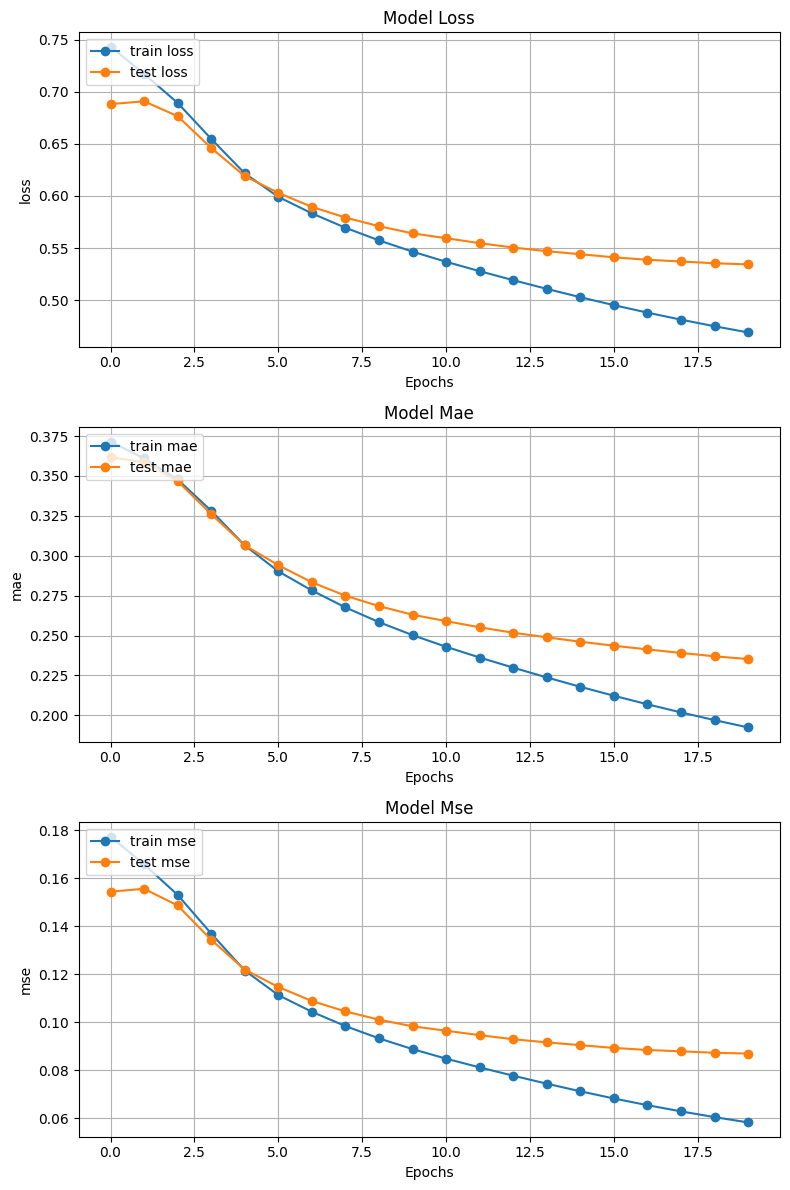

In [42]:
metrics = ["loss","mae","mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric],marker = "o",label = f"train {metric}")
    ax.plot(history.history[f"val_{metric}"],marker = "o",label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    ax.legend(loc = "upper left")
    ax.grid(True)
plt.tight_layout()
plt.show()

In [43]:
def extract_weights(name,model):
    weights_layer = model.get_layer(name)
    weights = weights_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights


In [44]:
anime_weights = extract_weights("anime_embeddings",model)

In [45]:
user_weights = extract_weights("user_embeddings",model)

#### Reading Anime.csv

In [46]:
df = pd.read_csv(INPUT_DIR+"/anime.csv" ,low_memory=True)

In [47]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [48]:
df = df.replace("Unknown",np.nan)

In [49]:
def get_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
        return name
    except:
        print("Error")

In [50]:
df['anime_id'] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:get_anime_name(x))

In [51]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [52]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [53]:
get_anime_name(67)

'Basilisk'

In [54]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

In [55]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [56]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [57]:
df = df [["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [58]:
df.columns

Index(['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type',
       'Premiered', 'Members'],
      dtype='object')

In [59]:
def get_anime_frame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [60]:
get_anime_frame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### Anime_with_synopsis.csv

In [61]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [62]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv" ,usecols=cols)

In [63]:
(synopsis_df.MAL_ID == 3793).sum()

np.int64(0)

In [64]:
def get_synopsis(anime,df):
    if isinstance(anime,int):
        return df[df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return df[df.Name == anime].sypnopsis.values[0]

#### Content Based Recommendation System

In [65]:
pd.set_option("max_colwidth",None)

In [66]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [95]:
def find_similar_animes(name,
                        anime_weights,
                        anime2anime_encoding,
                        anime2anime_decoding,
                        df,
                        synopsis_df,
                        n=10,
                        return_dist = False,
                        neg=False):
    try:
        index = get_anime_frame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoding.get(index)
        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n=n+1

        if neg :
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists , closest
        
        similarity_array = []
        for close in closest:

            decoded_id = anime2anime_decoding.get(close)

            print(decoded_id)

            anime_frame = get_anime_frame(decoded_id,df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.values[0]
            similarity = dists[close]

            similarity_array.append(
                {
                    "anime_id" :decoded_id,
                    "name": anime_name,
                    "genre": genre,
                    "similarity": similarity,
                }
            )
        
        frame = pd.DataFrame(similarity_array).sort_values(by ="similarity" ,ascending=False)
        return frame[frame.anime_id!=index].drop(["anime_id"],axis=1)
    except Exception as e: 
        print("Error",e)

In [68]:
find_similar_animes(
    "Doraemon the Movie:Nobita and the Birth of Japan 2016",
    anime_weights,
    anime2anime_encoding,
    anime2anime_decoding,
    df,
    synopsis_df
)

Anime closest to Doraemon the Movie:Nobita and the Birth of Japan 2016
2434
Error index 0 is out of bounds for axis 0 with size 0


In [69]:
anime2anime_decoding.get(3793)

9724

In [70]:
get_synopsis(793,synopsis_df)

"Summer break has arrived, but while his other classmates are out having fun, Kimihiro Watanuki continues to work as compensation for the eccentric Yuuko in her shop. With the spirits and supernatural phenomena that bother him lessening, he pays his dues by cleaning, cooking, and doing whatever else the apparently lazy Yuuko needs. Watanuki, however, gets involved in a new predicament when Yuuko receives a mysterious invitation to a mansion whose owner seeks Yuuko's wish-granting ability. When he, Yuuko, and his classmate Shizuka Doumeki make their way to the peculiar residence, they meet others who were summoned by the same strange invitation. All of them are collectors of various unique items, drawn there by the chance to expand their collections. But as the collectors begin to disappear one by one, Watanuki and his companions must solve the mystery and put the case to rest, or find themselves in risk of danger."

In [71]:
get_anime_frame("Doraemon the Movie:Nobita and the Birth of Japan 2016",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10860,31201,Doraemon the Movie:Nobita and the Birth of Japan 2016,7.25,"Adventure, Comedy, Fantasy, Kids, Shounen",1,Movie,NaN,2565


In [72]:
df.sample(10)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
395,422,Stratos 4 OVA,6.73,"Comedy, Military, Sci-Fi, Shounen",2,OVA,NaN,2935
14807,38267,Sleeping Beauty,NaN,Music,1,Music,NaN,149
15804,39792,Keep Your Hands Off Eizouken!,8.17,"Adventure, Comedy, School, Seinen",12,TV,Winter 2020,211247
5684,9254,Mianhada Saranghanda,6.01,Drama,1,Movie,NaN,1580
16570,41212,Niplheim no Karyuudo,5.29,Hentai,NaN,ONA,NaN,883
11509,32767,Hane,5.3,Music,1,Music,NaN,267
2943,3300,Romance is in the Flash of the Sword II,6.12,"Action, Fantasy, Comedy, Hentai, Demons",6,OVA,NaN,1750
1124,1233,801 T.T.S. Airbats,6.51,"Action, Comedy, Military, Romance, Shounen",7,OVA,NaN,6218
13120,35535,Kaiten Mokuba ni Boku to Neko,NaN,"Music, Kids",1,Music,NaN,121
3423,3981,Classroom of Atonement,5.29,Hentai,2,OVA,NaN,2646


In [73]:
anime2anime_decoding.get(3793)

9724

In [74]:
anime2anime_encoding.get(9724)

3793

In [75]:
anime2anime_encoding

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [76]:
anime2anime_decoding

{0: 24833,
 1: 235,
 2: 36721,
 3: 40956,
 4: 31933,
 5: 5042,
 6: 7593,
 7: 21,
 8: 35446,
 9: 24,
 10: 22,
 11: 38034,
 12: 17251,
 13: 5762,
 14: 31580,
 15: 33253,
 16: 35028,
 17: 9513,
 18: 368,
 19: 11633,
 20: 31964,
 21: 33486,
 22: 31740,
 23: 1470,
 24: 1575,
 25: 2904,
 26: 1535,
 27: 28223,
 28: 226,
 29: 38671,
 30: 32872,
 31: 15,
 32: 71,
 33: 7661,
 34: 245,
 35: 263,
 36: 5258,
 37: 270,
 38: 24703,
 39: 15451,
 40: 8074,
 41: 11061,
 42: 28961,
 43: 34542,
 44: 14719,
 45: 20899,
 46: 26055,
 47: 34933,
 48: 37086,
 49: 1604,
 50: 22535,
 51: 189,
 52: 34599,
 53: 29575,
 54: 10620,
 55: 32182,
 56: 23755,
 57: 20,
 58: 1735,
 59: 35581,
 60: 5040,
 61: 30276,
 62: 34134,
 63: 6893,
 64: 11499,
 65: 29786,
 66: 16498,
 67: 28171,
 68: 32282,
 69: 9253,
 70: 3455,
 71: 22319,
 72: 10851,
 73: 40658,
 74: 29809,
 75: 25397,
 76: 2852,
 77: 1635,
 78: 1636,
 79: 40337,
 80: 39085,
 81: 857,
 82: 9721,
 83: 36625,
 84: 6987,
 85: 8577,
 86: 9849,
 87: 4010,
 88: 16642,
 

#### USER BASED RECOMMENDATION

In [77]:
def find_similar_users(item_input,
                       user_weights,
                       user2user_encoding,
                       user2user_decoding,
                       n=10,
                       return_dist = False,
                       neg = False):
    try:
        index = item_input
        encoded_index = user2user_encoding.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])

        sorted_dist = np.argsort(dists)

        n=n+1

        if neg :
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]
        
        if return_dist:
            return dists,closest
        
        similarity_array = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoding.get(close)
                similarity_array.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(similarity_array).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users!=item_input]
        return similar_users
    except Exception as e:
        print("Error",e)

In [78]:
find_similar_users(int(11880),user_weights,user2user_encoding,user2user_decoding)

,similar_users,similarity
9,5852,0.428293
8,3337,0.425814
7,2236,0.408361
6,12332,0.407450
5,6881,0.405040
4,10472,0.390193
3,12056,0.388484
2,8314,0.386162
1,3001,0.382208
0,6758,0.377914


In [79]:
def show_word_cloud(all_genres):
    genre_cloud = WordCloud(width=700,
                            height=400,
                            background_color='white',
                            colormap="gnuplot").generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8))
    plt.imshow(genre_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [80]:
from collections import defaultdict

In [81]:
def get_fav_genre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []

    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] +=1
    if plot:
        show_word_cloud(all_genres)
    return genres_list 

In [82]:
x = get_anime_frame(1,df)

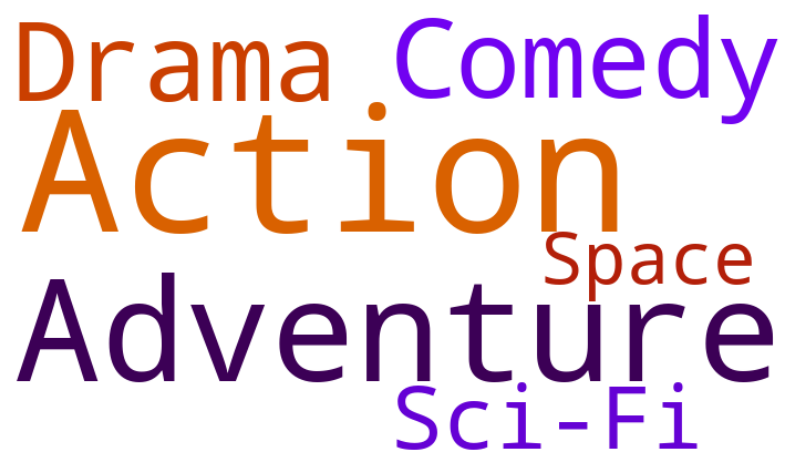

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [83]:
get_fav_genre(x,plot=True)

In [98]:
def get_user_preferences(user_id,rating_df,df,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    if animes_watched_by_user.empty:
        return []

    user_rating_percentile = np.percentile(animes_watched_by_user.rating,75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user =(
        animes_watched_by_user.sort_values(by='rating',ascending=False).anime_id.values
    ) 

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]

    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        get_fav_genre(anime_df_rows,True)

    return anime_df_rows

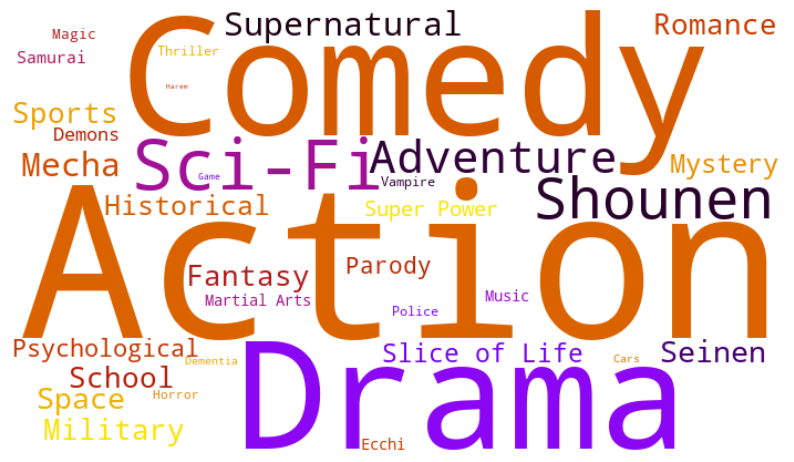

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [85]:
get_user_preferences(11880,rating_df,df,True)

In [86]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = get_anime_frame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = get_synopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [87]:
similar_users = find_similar_users(int(11880),user_weights,user2user_encoding,user2user_decoding)

In [88]:
user_pref = get_user_preferences(11880,rating_df,df,False)

In [89]:
get_user_recommendations(similar_users,
                         user_pref,
                         df,
                         synopsis_df,
                         rating_df)

,n,anime_name,Genres,Synopsis
0,9,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1,9,Toradora!,"Slice of Life, Comedy, Romance, School","uuji Takasu is a gentle high school student with a love for housework; but in contrast to his kind nature, he has an intimidating face that often gets him labeled as a delinquent. On the other hand is Taiga Aisaka, a small, doll-like student, who is anything but a cute and fragile girl. Equipped with a wooden katana and feisty personality, Taiga is known throughout the school as the ""Palmtop Tiger."" One day, an embarrassing mistake causes the two students to cross paths. Ryuuji discovers that Taiga actually has a sweet side: she has a crush on the popular vice president, Yuusaku Kitamura, who happens to be his best friend. But things only get crazier when Ryuuji reveals that he has a crush on Minori Kushieda—Taiga's best friend! Toradora! is a romantic comedy that follows this odd duo as they embark on a quest to help each other with their respective crushes, forming an unlikely alliance in the process."
2,9,"Love, Chunibyo & Other Delusions!","Slice of Life, Comedy, Drama, Romance, School","Everybody has had that stage in their life where they have thought themselves to be special, different from the masses of ordinary humans. They might go as far as seeing themselves capable of wielding mystical powers, or maybe even believe themselves to have descended from a fantasy realm. This ""disease"" is known as ""chuunibyou"" and is often the source of some of the most embarrassing moments of a person's life. For Yuuta Togashi, the scars that his chuunibyou has left behind are still fresh. Having posed as the ""Dark Flame Master"" during his middle school years, he looks back at those times with extreme embarrassment, so much so that he decides to attend a high school far away where nobody will recognize him. Putting his dark history behind him, he longs to live a normal high school life. Unfortunately, he hasn't escaped his past yet: enter Rikka Takanashi, Yuuta's new classmate and self-declared vessel of the ""Wicked Eye."" As this eccentric young girl crashes into Yuuta's life, his dream of an ordinary, chuunibyou-free life quickly crumbles away. In this hilarious and heartwarming story of a boy who just wants to leave his embarrassing memories behind, the delusions of old are far from a thing of the past."
3,8,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one in

#### HYBRID RECOMMENDATION_SYSTEM

In [99]:
def hybrid_recommendation(user_id,
                          user_weight=0.5,
                          content_weight = 0.5):
    
    #User Recommendation
    similar_users = find_similar_users(user_id,user_weights,user2user_encoding,user2user_decoding)
    user_pref = get_user_preferences(user_id,rating_df,df,False)
    user_recommended_anime = get_user_recommendations(similar_users, user_pref,df,synopsis_df,rating_df)

    user_recommended_anime_list = user_recommended_anime["anime_name"].to_list()

    #Content Recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime,anime_weights,anime2anime_encoding,anime2anime_decoding,df,synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No Similar anime found for {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight
    
    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight
    
    sorted_animes = sorted(combined_scores.items(), key = lambda x : x[1] , reverse=True)

    return[anime for anime,_ in sorted_animes[:10]]
    

In [103]:
hybrid_recommendation(112)

Anime closest to Code Geass:Lelouch of the Rebellion
121
11757
6547
19815
30276
16498
9253
5114
1535
2904
1575
Anime closest to Bakuman.
11741
19363
9989
4181
11061
9253
5258
2904
7674
10030
12365
Anime closest to Fullmetal Alchemist:Brotherhood
199
32281
11061
30276
9253
121
16498
1575
2904
1535
5114
Anime closest to Nisekoi:False Love
6347
27787
15583
28121
23847
28171
17895
23277
14813
13759
18897
Anime closest to Toradora!
19815
32281
31240
2167
11757
16498
2904
14741
6547
9253
4224
Anime closest to Steins;Gate
6547
5081
4224
32281
1535
10087
11741
5114
1575
2904
9253
Anime closest to My Love Story!!
32542
9656
6045
28677
22789
26349
29067
27989
32828
28825
28297
Anime closest to ERASED
19815
28851
1535
28891
30276
31964
23273
16498
31240
32281
31043
Anime closest to Spirited Away
32281
2236
16498
513
2890
1535
512
523
164
431
199
Anime closest to Summer Wars
2167
2890
6547
431
1689
47
513
199
164
2236
5681


['Steins;Gate',
 'Code Geass:Lelouch of the Rebellion R2',
 'Death Note',
 'Attack on Titan',
 'Your Name.',
 'Angel Beats!',
 'Code Geass:Lelouch of the Rebellion',
 'Bakuman.',
 'Fullmetal Alchemist:Brotherhood',
 'Spirited Away']